#### 參考資料

https://towardsdatascience.com/semantic-hand-segmentation-using-pytorch-3e7a0a0386fa

https://github.com/qubvel/segmentation_models.pytorch

In [92]:
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import glob
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader
from torch import optim
import tqdm
from torch.nn import Module
from torch.nn import Module as module
import tqdm

import os, cv2, random, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as albu

In [93]:
deeplab = models.segmentation.deeplabv3_resnet50(pretrained=0, 
                                                 progress=1, 
                                                 num_classes=10)

In [94]:
class SegModel(nn.Module):
    def __init__(self):
        super(SegModel,self).__init__()
        self.dl = deeplab
        
    def forward(self, x):
        y = self.dl(x)['out']
        return y

In [95]:
class segDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(self, images_dir, masks_dir=None, CLASSES=None, classes=None, augmentation=None, preprocessing=None):
        
        self.ids = os.listdir(images_dir)
        self.ids.sort()
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        
        if masks_dir:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None
        
        # convert str names to class values on masks
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.masks_fps:
            mask = cv2.imread(self.masks_fps[i], 0)
            
            # extract certain classes from mask (e.g. cars)
            masks = [(mask == v) for v in self.class_values]
            mask = np.stack(masks, axis=-1).astype('float')
            
            # apply augmentations
            if self.augmentation:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
                
            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
                
            return image, mask
        
        else:
            # apply augmentations
            if self.augmentation:
                sample = self.augmentation(image=image)
                image = sample['image']
                
            # apply preprocessing
            if self.preprocessing:
                sample = self.preprocessing(image=image)
                image = sample['image']
            
            return image
        
        
    def __len__(self):
        return len(self.ids)

In [96]:
import smpgit.segmentation_models_pytorch as smp
import args
from utils import get_training_augmentation, get_validation_augmentation, get_preprocessing, create_subfolders, fns2subfolders
images_dir = './data/rgb_images/'
masks_dir = './data/semantic_annotations/semantic_annotations/gtLabels/'
CLASSES = ['void', 'road', 'lanemarks', 'curb', 'person', 'rider','vehicles', 'bicycle','motorcycle', 'traffic_sign']
preprocessing_fn = smp.encoders.get_preprocessing_fn('se_resnext50_32x4d', 'imagenet')

In [97]:
trainDataset = segDataset(images_dir + 'tr/',masks_dir + 'tr/',CLASSES,CLASSES,
                          augmentation=get_validation_augmentation(), 
                          preprocessing=get_preprocessing(preprocessing_fn))
validDataset = segDataset(images_dir + 'va/',masks_dir + 'va/',CLASSES,CLASSES,
                          augmentation=get_validation_augmentation(), 
                          preprocessing=get_preprocessing(preprocessing_fn))
testDataset = segDataset(images_dir + 'te/',masks_dir + 'te/',CLASSES,CLASSES,
                          augmentation=get_validation_augmentation(), 
                          preprocessing=get_preprocessing(preprocessing_fn))

In [98]:

# trainDataset = SegDataset('data', 'rgb_images/tr', 'semantic_annotations/semantic_annotations/gtLabels/tr')
# validDataset = SegDataset('data', 'rgb_images/va', 'semantic_annotations/semantic_annotations/gtLabels/va')
# testDataset = SegDataset('data', 'rgb_images/te', 'semantic_annotations/semasemantic_annotations/semantic_annotations/gtLabels/trntic_annotations/gtLabels/te')


In [99]:
batchSize = 2

In [100]:
trainLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle=True, drop_last=True)
validLoader = DataLoader(validDataset, batch_size = batchSize, shuffle=True, drop_last=True)
testLoader = DataLoader(testDataset, batch_size = batchSize, shuffle=True, drop_last=True)


In [101]:
def meanIOU(target, predicted):
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    iousum = 0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        intersection = np.logical_and(target_arr, predicted_arr).sum()
        union = np.logical_or(target_arr, predicted_arr).sum()
        if union == 0:
            iou_score = 0
        else :
            iou_score = intersection / union
        iousum +=iou_score
        
    miou = iousum/target.shape[0]
    return miou

In [102]:
def pixelAcc(target, predicted):    
    if target.shape != predicted.shape:
        print("target has dimension", target.shape, ", predicted values have shape", predicted.shape)
        return
        
    if target.dim() != 4:
        print("target has dim", target.dim(), ", Must be 4.")
        return
    
    accsum=0
    for i in range(target.shape[0]):
        target_arr = target[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        predicted_arr = predicted[i, :, :, :].clone().detach().cpu().numpy().argmax(0)
        
        same = (target_arr == predicted_arr).sum()
        a, b = target_arr.shape
        total = a*b
        accsum += same/total
    
    pixelAccuracy = accsum/target.shape[0]        
    return pixelAccuracy

In [103]:

model = SegModel()
#model = torch.nn.DataParallel(model, device_ids=[2,3])
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.BCEWithLogitsLoss ()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.8)

In [104]:
def training_loop(n_epochs, optimizer, lr_scheduler, model, loss_fn, train_loader, val_loader, lastCkptPath = None):
    if torch.cuda.is_available():  
        dev = "cuda:3" 
    else:  
        dev = "cpu"
    device = torch.device(dev)
    print(device)
    
    tr_loss_arr = []
    val_loss_arr = []
    meanioutrain = []
    pixelacctrain = []
    meanioutest = []
    pixelacctest = []
    prevEpoch = 0
    
    if lastCkptPath != None :
        checkpoint = torch.load(lastCkptPath)
        prevEpoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
                    tr_loss_arr =  checkpoint['Training Loss']
        val_loss_arr =  checkpoint['Validation Loss']
        meanioutrain =  checkpoint['MeanIOU train']
        pixelacctrain =  checkpoint['PixelAcc train']
        meanioutest =  checkpoint['MeanIOU test']
        pixelacctest =  checkpoint['PixelAcc test']
        print("loaded model, ", checkpoint['description'], "at epoch", prevEpoch)
    
    
    
    for epoch in range(0, n_epochs):
        train_loss = 0.0
        pixelacc = 0
        meaniou = 0
        
        pbar = tqdm.tqdm(train_loader, total = len(train_loader))
        model.to(device)
        for X, y in pbar:
            #torch.cuda.empty_cache()
            model.to(device).train()
            X = X.to(device).float()
            y = y.to(device).float()
            ypred = model(X).to(device)
            loss = loss_fn(ypred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            tr_loss_arr.append(loss.item())
            meanioutrain.append(meanIOU(y, ypred))
            pixelacctrain.append(pixelAcc(y, ypred))
            pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                              'Training Loss': np.mean(tr_loss_arr),
                              'Mean IOU': np.mean(meanioutrain),
                              'Pixel Acc': np.mean(pixelacctrain)
                             })
            
        with torch.no_grad():
            
            val_loss = 0
            pbar = tqdm.tqdm(val_loader, total = len(val_loader))
            for X, y in pbar:
                #torch.cuda.empty_cache()
                X = X.to(device).float()
                y = y.to(device).float()
                model.eval()
                ypred = model(X)
                
                val_loss_arr.append(loss_fn(ypred, y).item())
                pixelacctest.append(pixelAcc(y, ypred))
                meanioutest.append(meanIOU(y, ypred))
                
                pbar.set_postfix({'Epoch':epoch+1+prevEpoch, 
                                  'Validation Loss': np.mean(val_loss_arr),
                                  'Mean IOU': np.mean(meanioutest),
                                  'Pixel Acc': np.mean(pixelacctest)
                                 })
        
        
        
        checkpoint = {
            'epoch':epoch+1+prevEpoch,
            'description':"add your description",
            'state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'Training Loss': tr_loss_arr,
            'Validation Loss':val_loss_arr,
            'MeanIOU train':meanioutrain, 
            'PixelAcc train':pixelacctrain, 
            'MeanIOU test':meanioutest, 
            'PixelAcc test':pixelacctest
        }
        torch.save(checkpoint, 'checkpoints/checkpointhandseg'+str(epoch+1+prevEpoch)+'.pt')
        lr_scheduler.step()
        
    return tr_loss_arr, val_loss_arr, meanioutrain, pixelacctrain, meanioutest, pixelacctest

In [105]:
#lastCkptPath = 'checkpoints/checkpointhandseg6.pt'
# import os
# os.getcwd()

In [106]:
# 取最新的 checkpoints
import glob
import os

list_of_files = glob.glob('./checkpoints/*') # * means all if need specific format then *.csv
lastCkptPath = max(list_of_files, key=os.path.getctime)
print(lastCkptPath)

./checkpoints/checkpointhandseg18.pt


In [53]:
#call the training loop, 
#make sure to pass correct checkpoint path, or none if starting with the training

retval = training_loop(3, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss_fn, 
                       trainLoader, 
                       validLoader,
                       lastCkptPath)

cuda:3


  0%|          | 0/3293 [00:00<?, ?it/s]

loaded model,  add your description at epoch 15


 96%|█████████▌| 3147/3293 [1:13:19<03:28,  1.43s/it, Epoch=17, Training Loss=0.0094, Mean IOU=0.963, Pixel Acc=0.982] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [112]:
retval = training_loop(3, 
                       optimizer, 
                       lr_scheduler, 
                       model, 
                       loss_fn, 
                       trainLoader, 
                       validLoader, 
                       'checkpoints/checkpointhandseg18.pt')

cuda:3


  0%|          | 0/3293 [00:00<?, ?it/s]

loaded model,  add your description at epoch 18


  0%|          | 9/3293 [00:14<1:26:17,  1.58s/it, Epoch=19, Training Loss=0.00919, Mean IOU=0.964, Pixel Acc=0.983]


KeyboardInterrupt: 

In [14]:
3293*18

59274

In [3]:
os.listdir('./checkpoints/')

['checkpointhandseg9.pt',
 'checkpointhandseg13.pt',
 'checkpointhandseg4.pt',
 'checkpointhandseg5.pt',
 'checkpointhandseg1.pt',
 'checkpointhandseg14.pt',
 'checkpointhandseg12.pt',
 'checkpointhandseg2.pt',
 'checkpointhandseg10.pt',
 'checkpointhandseg17.pt',
 'checkpointhandseg15.pt',
 'checkpointhandseg16.pt',
 'checkpointhandseg11.pt',
 'checkpointhandseg18.pt',
 'checkpointhandseg7.pt',
 'checkpointhandseg3.pt',
 'checkpointhandseg8.pt',
 'checkpointhandseg6.pt']

In [6]:
checkpoint = torch.load('./checkpoints/checkpointhandseg18.pt')

# 視覺化結果

In [8]:
checkpoint.keys()

dict_keys(['epoch', 'description', 'state_dict', 'optimizer_state_dict', 'Training Loss', 'Validation Loss', 'MeanIOU train', 'PixelAcc train', 'MeanIOU test', 'PixelAcc test'])

In [58]:
Training_Loss = []
Validation_Loss = []
MeanIOU_train = []
PixelAcc_train = []
MeanIOU_test = []
PixelAcc_test = []

for j in range(1,19):
    checkpoint = torch.load('./checkpoints/checkpointhandseg{}.pt'.format(j))
    print(checkpoint['epoch'])
    
    for num, i in enumerate(checkpoint.keys()):
        if num >=4:
            print(i,'：',np.mean(checkpoint[i]))
            if num == 4:
                Training_Loss.append(np.mean(checkpoint[i]))
            elif num == 5:
                Validation_Loss.append(np.mean(checkpoint[i]))
            elif num == 6:
                MeanIOU_train.append(np.mean(checkpoint[i]))
            elif num == 7:
                PixelAcc_train.append(np.mean(checkpoint[i]))
            elif num == 8:
                MeanIOU_test.append(np.mean(checkpoint[i]))
            elif num == 9:
                PixelAcc_test.append(np.mean(checkpoint[i]))



1
Training Loss ： 0.0187450865106281
Validation Loss ： 0.019508944816406987
MeanIOU train ： 0.9292391944822561
PixelAcc train ： 0.968029592217619
MeanIOU test ： 0.9211534902707004
PixelAcc test ： 0.9649669954313445
2
Training Loss ： 0.016820876189271954
Validation Loss ： 0.017454322759195746
MeanIOU train ： 0.9348381136329367
PixelAcc train ： 0.9706066923089454
MeanIOU test ： 0.9303146014757436
PixelAcc test ： 0.9686464636053432
3
Training Loss ： 0.015560437937556825
Validation Loss ： 0.016509317461928446
MeanIOU train ： 0.938941655471495
PixelAcc train ： 0.9724139548340169
MeanIOU test ： 0.9329243834745292
PixelAcc test ： 0.970136353436236
4
Training Loss ： 0.014697785295176694
Validation Loss ： 0.016022848602953093
MeanIOU train ： 0.9418813934349064
PixelAcc train ： 0.973693738557931
MeanIOU test ： 0.9343960718852756
PixelAcc test ： 0.9709397234650564
5
Training Loss ： 0.013943262645822598
Validation Loss ： 0.01562042957344013
MeanIOU train ： 0.9446675106907194
PixelAcc train ： 0.974

In [89]:
# Training_Loss
# Validation_Loss
# MeanIOU_train
# PixelAcc_train
# MeanIOU_test
# PixelAcc_test

# plt.plot(MeanIOU_test)
# plt.title('MeanIOU_test',fontsize=14)
# plt.xlabel('epoch')

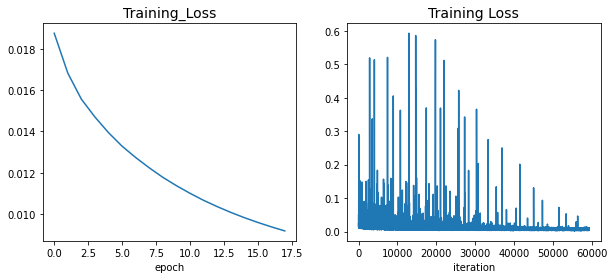

In [83]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(Training_Loss)
plt.title('Training_Loss',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['Training Loss'])
plt.title('Training Loss',fontsize=14)
plt.xlabel('iteration')
plt.show()

Text(0.5, 0, 'iteration')

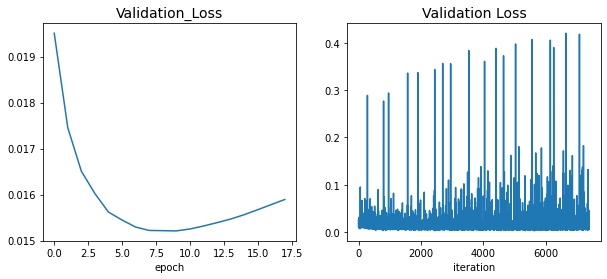

In [88]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(Validation_Loss)
plt.title('Validation_Loss',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['Validation Loss'])
plt.title('Validation Loss',fontsize=14)
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

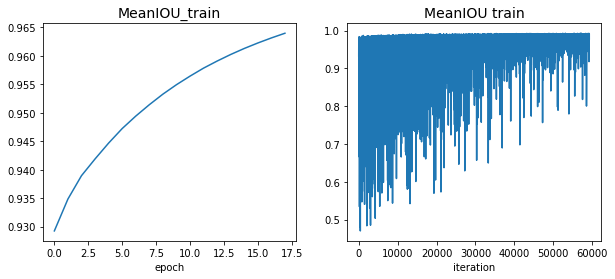

In [84]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(MeanIOU_train)
plt.title('MeanIOU_train',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['MeanIOU train'])
plt.title('MeanIOU train',fontsize=14)
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

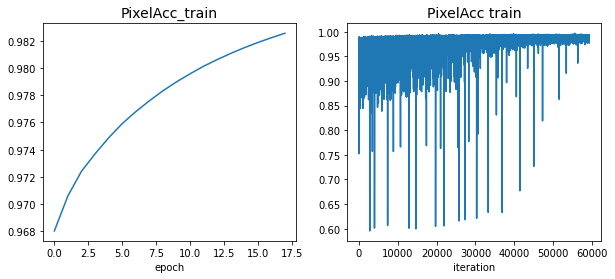

In [87]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(PixelAcc_train)
plt.title('PixelAcc_train',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['PixelAcc train'])
plt.title('PixelAcc train',fontsize=14)
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

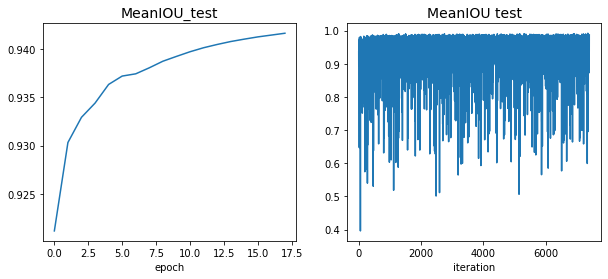

In [85]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(MeanIOU_test)
plt.title('MeanIOU_test',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['MeanIOU test'])
plt.title('MeanIOU test',fontsize=14)
plt.xlabel('iteration')

Text(0.5, 0, 'iteration')

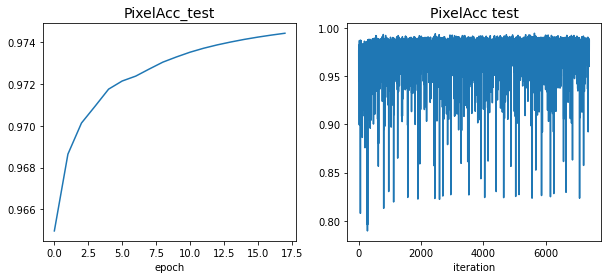

In [86]:
f = plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(PixelAcc_test)
plt.title('PixelAcc_test',fontsize=14)
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(checkpoint['PixelAcc test'])
plt.title('PixelAcc test',fontsize=14)
plt.xlabel('iteration')

In [120]:
#can pass np array or path to image file
def Segmentimage(pathtest):
    
    if isinstance(pathtest, np.ndarray):
        img = Image.fromarray(pathtest)
    else :
        img = Image.open(pathtest)
    
    preprocess = transforms.Compose([transforms.Resize((288, 384), 2),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    Xtest = preprocess(img)
    
    checkpoint = torch.load('checkpoints/checkpointhandseg7.pt')
    model = SegModel()
    model.load_state_dict(checkpoint['state_dict'])
    with torch.no_grad():
        model.eval()
        if torch.cuda.is_available():
            dev = "cuda:0" 
        else:  
            dev = "cpu"
        device = torch.device(dev)
        model.to(device)
        Xtest = Xtest.to(device).float()
        ytest = model(Xtest.unsqueeze(0).float())
        ypos = ytest[0, 1, :, :].clone().detach().cpu().numpy()
        yneg = ytest[0, 0, :, :].clone().detach().cpu().numpy()
        ytest = ypos >= yneg
    
    mask = ytest.astype('float32')
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    mask = cv2.dilate(mask,kernel,iterations = 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

In [121]:
def getcoloredMask(image, mask):
    color_mask = np.zeros_like(image)
    color_mask[:, :, 1] += mask.astype('uint8') * 250
    masked = cv2.addWeighted(image, 1.0, color_mask, 1.0, 0.0)
    return masked

In [132]:
images_dir = './data/rgb_images(test_set)'
ids = os.listdir(images_dir)
ids.sort()
images_fps = [os.path.join(images_dir, image_id) for image_id in ids]
#masks_fps = [os.path.join(masks_dir, image_id) for image_id in ids]

        
# read data
image = cv2.imread(images_fps[i])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
i = 0
while(True):
    ret, frame = cap.read()
    
    frame = cv2.resize(image, (384,288))
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if i%5 == 0:
        i=0
        mask = Segmentimage(rgb)
        colmask = getcoloredMask(frame, mask)
    
    cv2.imshow('color', np.hstack((frame, colmask)))
    #cv2.imshow('color', np.hstack((frame, colmask)))
    key = cv2.waitKey(24)
    if key & 0xFF == ord('q'):
        break
    i+=1
#cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.2) /tmp/pip-req-build-itd46xp8/opencv/modules/highgui/src/window.cpp:679: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [126]:
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [133]:
3465+3465


6930